# **Customer lifetime value**

Customer lifetime value (CLV) is a measure of customer profitability over time. In another word, it is a single dollar amount that measures the potential profit/loss of a customer to a business. Depends on the metrics you are after, it could be total purchase, user behaviours like number of logins etc. 

In this Analysis, I will be looking at the UK eCommerce data which is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts and many customers of the company are wholesalers. This Dataset can be found on on [Kaggle.com](https://www.kaggle.com/carrie1/ecommerce-data)

### **Why CLV?**

- Enables you to segment your customer inorder to focus on the most profitable one(s).
- Identify characteristic and features of valuable customers.
- Determine how to allocate resources among customers.
- Enables you with a baseline of what a company should pay to aquire different customers

<br>

### **Table of content**


1. **Data** <br>
    1.1. Import datasets <br>
    1.2. General data checks (missing values, outliers, unique values, data types) <br>
    1.3. Data cleaning 
    
2. **Exploratory data analysis (EDA)** <br>
    2.1. Datetime related visualization <br> 
    2.2. Products <br>
    2.3. Customers <br>
    2.4. Countries <br>
    
3. **CLV Analysis** <br>
    3.1. Calculate customer lifetime value <br>
    3.2. Distinguish active customers from inactive customers <br>
    3.3. Generate transaction forecasts for individual customers <br>
    3.4. Predict the purchase volume of the entire customer base <br>

#### **Importing Libraries and Datasets**

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Convert numbers format
import humanize

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Helper functions
# from plot_functions import func_barplot_autoplot, func_distplot_autoplot, func_scatterplot_autoplot

import folium
from folium import plugins 
from folium.plugins import HeatMap

In [2]:
# Set default settings
sns.set_style('darkgrid') # Grey background for visualization
pd.set_option('display.max_columns', None) # Expandable dataframe to display all columns
pd.options.display.float_format = '{:.2f}'.format # Convert scientific (1e9) to readable format 

#### **1.1. Import datasets**

In [3]:
# Import datasets (2 csv files)
df = pd.concat(map(pd.read_csv, ['data/online_retail_09_10.csv', 'data/online_retail_10_11.csv']))
df.reset_index(drop=True, inplace=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.00,United Kingdom


#### **1.2. General data checks**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   InvoiceNo    1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   UnitPrice    1067371 non-null  float64
 6   CustomerID   824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     243007
Country             0
dtype: int64

In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,1067371.00,1067371.00,824364.00
mean,9.94,4.65,15324.64
std,172.71,123.55,1697.46
min,-80995.00,-53594.36,12346.00
25%,1.00,1.25,13975.00
50%,3.00,2.10,15255.00
75%,10.00,4.15,16797.00
max,80995.00,38970.00,18287.00


In [7]:
num_invoices_returned_items = len(df.loc[df.Quantity < 0])
num_returned_items = abs(df.loc[df.Quantity < 0]['Quantity'].sum())
amount_returned_items = round(sum(abs(df.loc[df.Quantity < 0]['Quantity'] * df.loc[df.Quantity < 0]['UnitPrice'])), 2)
num_unique_invoices = len(df.InvoiceNo.unique())

print(f'Total number of invoices of returned items: {num_invoices_returned_items}, total number of returned items: {num_returned_items}, and total amount is ${amount_returned_items}')
print(f'Total unique invoices is: {num_unique_invoices}')

Total number of invoices of returned items: 22950, total number of returned items: 1064078, and total amount is $1527041.43
Total unique invoices is: 53628


In [8]:
num_missing_cust_ids = len(df.loc[df.CustomerID.isnull()])
num_unique_cust = len(df.CustomerID.unique())

print(f'Total missing customer ids are: {num_missing_cust_ids}. Available unique cutomers are: {num_unique_cust}')

Total missing customer ids are: 243007. Available unique cutomers are: 5943


In [5]:
# Convert Invoice Date into Datetime type

df.InvoiceDate = pd.to_datetime(df.InvoiceDate)

#### **Quick Observation**

- **Data Types**: InvoiceDate needs to be datetime, UnitPrice and Quantity will be converted to be int
- **Total Records**: 1,067,371 records with 
- **Missing Values:** We have 4382 missing values in the description column and 243007 in the customer id.
- **Unit Price:** We have values below zero which I assume they are returned items and we have extremely large numbers which most likely to be inserted by mistake (will be considered as *outliers*). Also 50% of the items we have in this dataset are below $2
- **Quantity** Similar to unit price column, values below zero are returned items and exteremely large numbers will be considered as outliers
- **Others**: There are 5943 customers and 53628 unique invoices. 

In [9]:
def distribution_plot(feature, title):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x = feature)
    plt.title(title)
    plt.show()

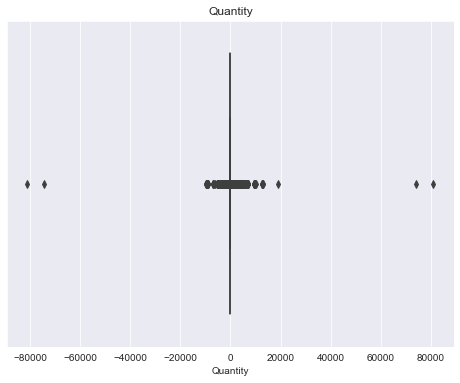

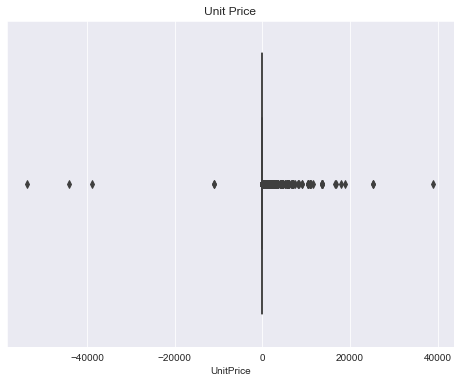

In [10]:
dict_features = {
    'Quantity': 'Quantity', 
    'UnitPrice': 'Unit Price'
}

for k, v in dict_features.items():
    distribution_plot(feature = df[k].dropna(), title = v)

#### **1.2. Data cleaning**

In [6]:
# After checking random records of customers where their IDs are missing, I could not reach to a way to fill them out.\
# I decided to remove them.

df = df.loc[~(df.CustomerID.isnull())]

In [7]:
# Remove records where price or quantity below zero (returned items) from the df and copy them into a new dataframe for analysis

returned_items = df.loc[(df.Quantity <= 0) | (df.UnitPrice <= 0)].copy()
df = df.loc[~((df.Quantity <= 0) | (df.UnitPrice <= 0))]

In [13]:
# Check stocks that contains characters 

def check_stock_description(df):
    
    description_dict = {}

    for code in df.loc[df.StockCode.str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique():
        description_dict[code] = df.loc[df.StockCode.str.contains(code), 'Description'].str.strip().unique()[0]

    return pd.DataFrame(description_dict, index=[0]).T

In [14]:
check_stock_description(df)

,0
POST,POSTAGE
C2,CARRIAGE
M,"ART LIGHTS,FUNK MONKEY"
BANK CHARGES,Bank Charges
TEST001,This is a test product.
TEST002,This is a test product.
PADS,PADS TO MATCH ALL CUSHIONS
ADJUST,Adjustment by john on 26/01/2010 16
D,PINK SWEETHEART BRACELET
ADJUST2,Adjustment by Peter on Jun 25 2010


- **TEST002** and **TEST001**: are testing records.
- **BANK CHARGES**: From the title, it's bank charges and nothing to do with sales
- **C2**: From the description, it says carriage which means, delivery fees. UnitPrice for this stock is 50.00
- **POST** and **DOT**: It seems this stock. is related to postage fees. The price goes up for countries that are far away from the UK. *Graph below shows postage fee by country*
- **D**: Seems to be discounted items
- **ADJUS** and **ADJUST2**: Might be a record modified manually by someone called Peter and this dataset contains only 3 records.
- **PADS**: Seems to be complementary item goes with cushions and bserved 18 times in this dataset.
- **M**: Stock number contains 'M' or it's just 'M' and it seems to be sort of manual that usually comes with items for installation instructions. Stocks wit 'M' only have extremely high prices, between 1000 and 4000 times more than stocks that have 'M' beside numbers.
- **SP1002**: Observed in 2 records and seems to be special offer or something.


I will proceed with removing all records that contains the following **TEST002**, **TEST001**, **BANK CHARGES**, **ADJUS**, **ADJUST2**, **PADS**, **C2**, **POST** and **DOT**. 2,172 records will be deleted (0.2% of the dataset)

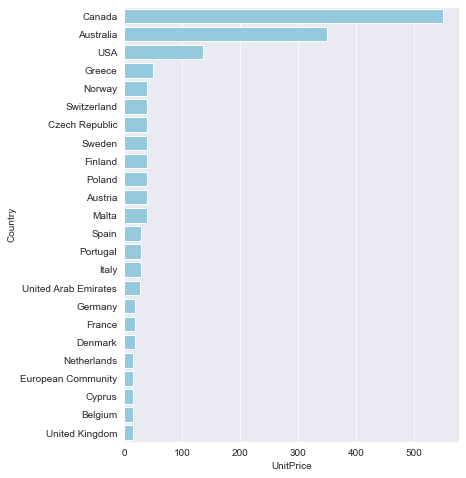

In [15]:
# Postage fees graph by country

plt.figure(figsize=(6, 8))
sns.barplot(
    data = df.loc[df.StockCode.str.contains('POST'), ['UnitPrice', 'Country']].groupby('Country').agg({'UnitPrice': 'median'}).reset_index().sort_values(by='UnitPrice', ascending=False),
    x = 'UnitPrice',
    y = 'Country',
    color = 'skyblue'
);

In [8]:
stocks_to_remove_list = ['TEST002', 'TEST001', 'BANK CHARGES', 'ADJUS', 'ADJUST2', 'PADS', 'C2', 'POST', 'DOT', 'M']
df = df.loc[~(df.StockCode.isin(stocks_to_remove_list))]

In [17]:
# Check missing values 

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

**Treating Outliers**

There are many ways of treaming outliers. Using basic statistical tests or machine learning algorithm to automatically identify the extreme points using clustering technique.

- Z-Score: We can use mean/standard deviation to remove outliers manualy or using z-score statistical test which re-scale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers. With commonly used threshold of 3, it means if the z-score value is greater than 3, that data point will be identified as outliers.

- IQR score: The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1. (*Wikipedia*). In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot (*above*) on the data. It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.

Once the outliers identified, we either remove there records from the dataset or we replace these values with NULL and treat them using mode, or median or mean. Since we have enough data to work with, and since this is just an example, I will go with the first approach and remove them to speed up the process using IQR.

In [7]:
def plot_histogram(data, bins, nfeatures, title):
    fig, ax = plt.subplots(ncols = nfeatures, figsize= (14, 4))
    for i in range(0, nfeatures):
        sns.histplot(data[i], bins = bins[i], ax = ax[i], kde=True)
        ax[i].set_title(title[i], pad = 10, weight= 'bold')
    plt.show()

In [8]:
def test_outliers(data, feature, qn, mn):
    
    # IQR 
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1

    qlow  = q1 - qn * iqr 
    qhigh = q3 + qn * iqr

    # Mean
    m = data.mean()
    std = data.std()

    mlow  = m - std * mn
    mhigh = m + std * mn
    
    print(f'IQR  --> {feature}: Low: {qlow}, High: {qhigh}')
    print(f'Mean --> {feature}: Low: {mlow}, High: {mhigh}\n')
    
    
    plot_histogram(
        data=[data, data[data < qhigh], data[data < mhigh]],
        title=['Before', 'After - IQR', 'After - Mean'],
        bins=[50,10,10],
        nfeatures=3
    )
    
    return 'Done'

IQR  --> Quantity: Low: -28.0, High: 42.0
Mean --> Quantity: Low: -418.27805431859656, High: 444.91576266983884



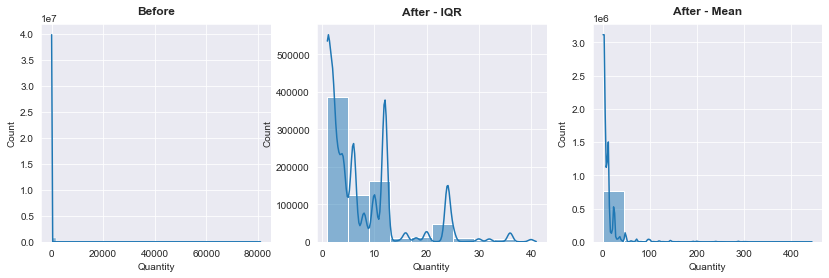

'Done'

In [9]:
test_outliers(
    data=df.Quantity, 
    feature='Quantity', 
    qn=3,
    mn=3
)

IQR  --> UnitPrice: Low: -6.25, High: 11.25
Mean --> UnitPrice: Low: -10.186338418198352, High: 16.056926317848394



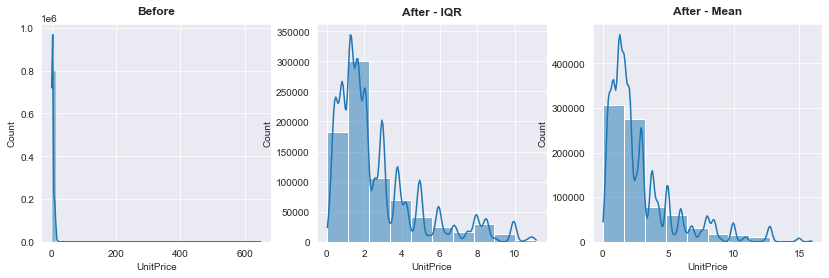

'Done'

In [10]:
test_outliers(
    data=df.UnitPrice, 
    feature='UnitPrice', 
    qn=3,
    mn=3
)

**Quantity**: Since this dataset contains mainly wholesalers, I will assume that quantity will be high. I will have my cutoff at 500 which mean I will be removing **0.1%** from the dataset<br>
**Price**: There are few items identified with high price like 195, 295.50 and Two items only with price of 649.50. No items were found between 400-600 range. I will leave the price feature as it is.

In [7]:
# df = df.loc[(df.Quantity <= 500)]

#### **Feature Engineering**

In [9]:
df['TotalSales'] = df.Quantity * df.UnitPrice
df['Quarter'] = df.InvoiceDate.dt.quarter
df['Month'] = df.InvoiceDate.dt.month
df['Hour'] = df.InvoiceDate.dt.hour
df['day'] = df.InvoiceDate.dt.day_name()
df['is_weekend'] = np.where(df.InvoiceDate.dt.weekday.isin([5,6]), 1, 0)

#### **EDA**

In [13]:
# Countries distribution

countries_lat_lon = pd.read_csv('data/countries.csv')
countries_summary = df.groupby('Country').agg({'InvoiceNo': 'nunique', 'CustomerID': 'nunique', 'TotalSales': 'sum'}).reset_index()
countries_summary = pd.merge(countries_summary, countries_lat_lon, left_on='Country', right_on='name').drop('name', axis=1)

coords_arr = countries_summary[['latitude', 'longitude']].values
trans_arr = countries_summary[['latitude', 'longitude', 'InvoiceNo']].values

In [14]:
def global_map():
    return folium.Map(location = [40.948424, 2.959616], zoom_start = 2.25, control_scale = True, tiles ='Cartodb dark_matter')

In [17]:
# Best views are: 'Stamen Terrain', 'Stamen Toner', 'Cartodb Positron'
m = global_map()

for i in range(0, len(coords_arr)):
    folium.CircleMarker(coords_arr[i]   , radius = 2, fill = True, opacity = 0.7, color = 'yellow').add_to(m)

plugins.HeatMap(data = trans_arr, radius = 18, gradient={0.4: 'red'}, max_zoom=50).add_to(m)
m

In [10]:
# Annotation function
def annotate_perct(ax_plot, total, add_height, rot):
    for p in ax_plot.patches:
        if np.isnan(p.get_height()):
            height = 0
            ax_plot.text(p.get_x() + p.get_width()/2., height, '', ha="center", va='center', fontsize=10, rotation = rot)  
        else:
            height = p.get_height()
            ax_plot.text(p.get_x() + p.get_width()/2., height + add_height, '{}\n{}%'.format(humanize.intcomma(int(height)), round((round(height / total, 3) * 100), 1)), ha="center", va='center', fontsize=10, rotation = rot)
            
            
# Count plot function
def func_countplot_autoplot(ncols, plot_width, plot_length, x, order, height, total, rot, title, xlabel, ylabel, xrot, palette):   
    
    if ncols == 1:
        plt.figure(figsize = (plot_width, plot_length))
        
        _ = sns.countplot(x = x, order = order, palette = palette) 
        annotate_perct(ax_plot = _, add_height= height, total= total, rot= rot)
        
        _.set_title(title, pad = 10, weight= 'bold')
        _.set_xlabel(xlabel)
        _.set_xticklabels(_.get_xticklabels(), rotation = xrot)
        _.set_ylabel(ylabel)
        plt.show()
        
    elif ncols < 5:    
        fig, ax = plt.subplots(ncols = ncols, figsize= (plot_width, plot_length))
        
        for i in range(0, ncols):
            sns.countplot(x = x[i], order = order[i], palette = palette[i], ax = ax[i]) 
            annotate_perct(ax_plot = ax[i], add_height= height[i], total= total[i], rot= rot[i])
            ax[i].set_title(title[i], pad = 10, weight= 'bold')
            ax[i].set_xlabel(xlabel[i])
            ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = xrot[i])
            ax[i].set_ylabel(ylabel[i])
        plt.show()
        
    else:
        print('Error. You can not plot more than 4 graphs in 1 row.')
        
            
# Bar plot function
def func_barplot_autoplot(ncols, plot_width, plot_length, x, y, hue, order, height, total, rot, title, xlabel, ylabel, xrot, palette, color):
    
    if ncols == 1:
        plt.figure(figsize = (plot_width, plot_length))
        
        _ = sns.barplot(x = x, y = y, hue = hue, order = order, palette = palette, color = color) 
        if total: annotate_perct(ax_plot = _, add_height= height, total= total, rot= rot)
        _.set_title(title, pad = 10, weight= 'bold')
        _.set_xlabel(xlabel)
        _.set_xticklabels(_.get_xticklabels(), rotation = xrot)
        _.set_ylabel(ylabel)
        plt.show()
    
    elif ncols < 5:
        fig, ax = plt.subplots(ncols = ncols, figsize= (plot_width, plot_length))

        for i in range(0, ncols): 
            sns.barplot(x = x[i], y = y[i], hue = hue[i], order = order[i], palette = palette[i], color = color[i], ax = ax[i]) 
            if total[i]: annotate_perct(ax_plot = ax[i], add_height= height[i], total= total[i], rot= rot[i])
            ax[i].set_title(title[i], pad = 10, weight= 'bold')
            ax[i].set_xlabel(xlabel[i])
            ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = xrot[i])
            ax[i].set_ylabel(ylabel[i])
        plt.show()
    
    else:
        print('Error. You can not plot more than 4 graphs in 1 row.')
        
    
# Scatter plot function    
def func_scatterplot_autoplot(ncols, plot_width, plot_length, x, y, title, xlabel, ylabel, xrot, palette):
    
    if ncols == 1:
        plt.figure(figsize = (plot_width, plot_length))
        _ = sns.scatterplot(x = x, y = y, palette = palette) 
        _.set_title(title, pad = 10, weight= 'bold')
        _.set_xlabel(xlabel)
        _.set_xticklabels(_.get_xticklabels(), rotation = xrot)
        _.set_ylabel(ylabel)
        plt.show()
    
    elif ncols < 5:
        fig, ax = plt.subplots(ncols = ncols, figsize= (plot_width, plot_length))
        for i in range(0, ncols):
            sns.scatterplot(x = x[i], y = y[i], palette = palette, ax = ax[i]) 
            ax[i].set_title(title[i], pad = 10, weight= 'bold')
            ax[i].set_xlabel(xlabel[i])
            ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = xrot[i])
            ax[i].set_ylabel(ylabel[i])
        plt.show()
    
    else:
        print('Error. You can not plot more than 4 graphs in 1 row.')

        
# Distribution / Histogram plot function            
def func_distplot_autoplot(ncols, plot_width, plot_length, x, title, xlabel, xrot, bins, rug, color):

    if ncols == 1:
        plt.figure(figsize = (plot_width, plot_length))
        _ = sns.distplot(x, color = color, bins = bins, rug = rug) 
        _.set_title(title, pad = 10, weight= 'bold')
        _.set_xlabel(xlabel)
        _.set_xticklabels(_.get_xticklabels(), rotation = xrot)
        plt.show()

    elif ncols < 5:
        fig, ax = plt.subplots(ncols = ncols, figsize= (plot_width, plot_length))
        for i in range(0, ncols):
            sns.distplot(x[i], color = color[i], bins = bins[i], rug = rug[i], ax = ax[i]) 
            ax[i].set_title(title[i], pad = 10, weight= 'bold')
            ax[i].set_xlabel(xlabel[i])
            ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = xrot[i])
        plt.show()
    
    else:
        print('Error. You can not plot more than 4 graphs in 1 row.')

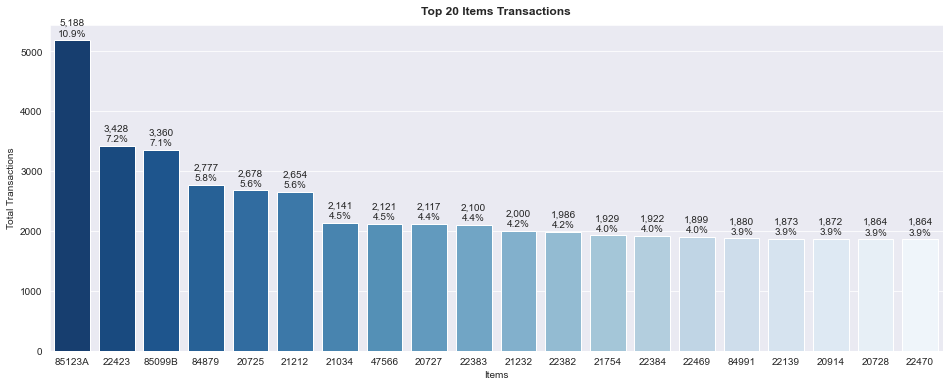

In [35]:
top_20_items = df.groupby('StockCode').size().reset_index().rename(columns={0:'counts'}).sort_values(by='counts', ascending=False)[:20]

func_barplot_autoplot( ncols       = 1,
                       plot_width  = 16,
                       plot_length = 6, 
                       x       = top_20_items.StockCode,
                       y       = top_20_items.counts,
                       hue     = None,
                       order   = None,
                       height  = 200, 
                       total   = top_20_items.counts.sum(), 
                       rot     = 0, 
                       title   = 'Top 20 Items Transactions', 
                       xlabel  = 'Items',
                       ylabel  = 'Total Transactions', 
                       xrot    = None,
                       color = None,
                       palette = 'Blues_r')

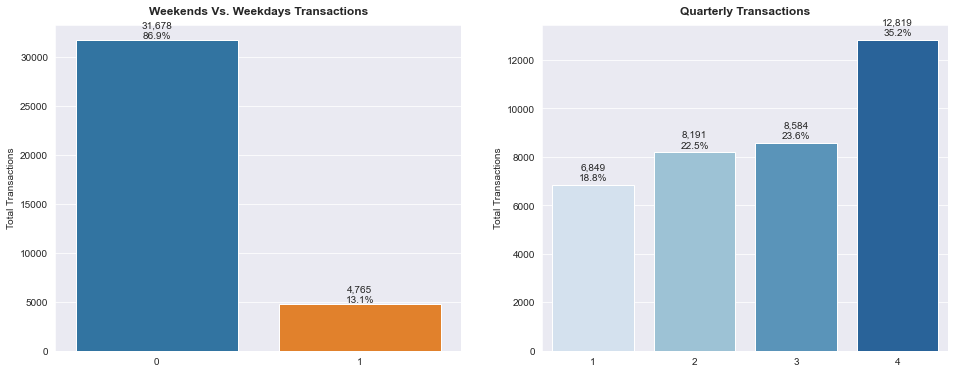

In [171]:
weekend_summary = df.groupby('is_weekend').agg({'InvoiceNo': 'nunique'}).reset_index().sort_values(by='is_weekend')
quarter_summary = df.groupby('Quarter').agg({'InvoiceNo': 'nunique'}).reset_index().sort_values(by='Quarter') 


func_barplot_autoplot( ncols       = 2,
                       plot_width  = 16,
                       plot_length = 6, 
                       x       = [weekend_summary.is_weekend, quarter_summary.Quarter],
                       y       = [weekend_summary.InvoiceNo, quarter_summary.InvoiceNo],
                       hue     = [None, None],
                       order   = [None, None],
                       height  = [1000, 500], 
                       total   = [weekend_summary.InvoiceNo.sum(), quarter_summary.InvoiceNo.sum()], 
                       rot     = [None, None], 
                       title   = ['Weekends Vs. Weekdays Transactions', 'Quarterly Transactions'], 
                       xlabel  = ['', ''], 
                       ylabel  = ['Total Transactions', 'Total Transactions'],
                       xrot    = [None, None],
                       color   = [None, None],
                       palette = [None, 'Blues'])

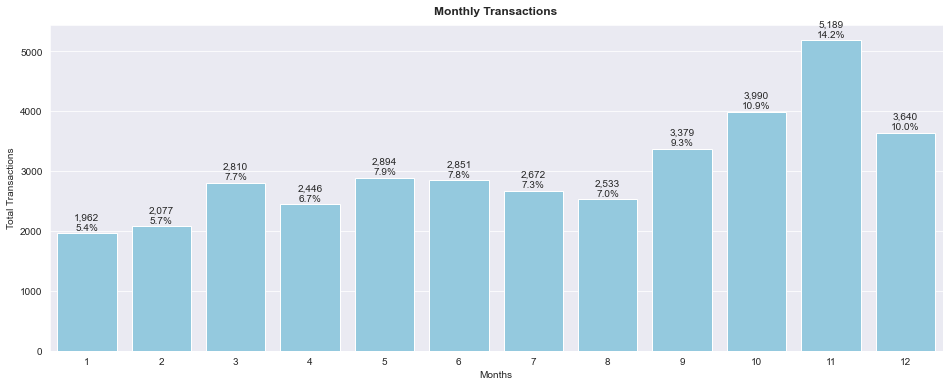

In [182]:
months_summary = df.groupby('Month').agg({'InvoiceNo': 'nunique'}).reset_index().sort_values(by='Month')

func_barplot_autoplot( ncols       = 1,
                       plot_width  = 16,
                       plot_length = 6, 
                       x       = months_summary.Month,
                       y       = months_summary.InvoiceNo,
                       hue     = None,
                       order   = None,
                       height  = 180, 
                       total   = months_summary.InvoiceNo.sum(), 
                       rot     = 0, 
                       title   = 'Monthly Transactions', 
                       xlabel  = 'Months',
                       ylabel  = 'Total Transactions', 
                       xrot    = None,
                       color   = 'skyblue',
                       palette = None)

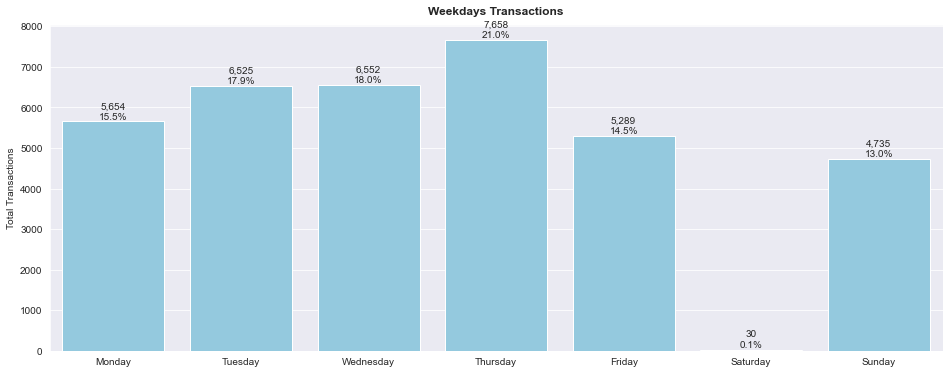

In [22]:
days_summary = df.groupby('day').agg({'InvoiceNo': 'nunique'}).reset_index()
days_orders  = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

func_barplot_autoplot( ncols       = 1,
                       plot_width  = 16,
                       plot_length = 6, 
                       x       = days_summary.day,
                       y       = days_summary.InvoiceNo,
                       hue     = None,
                       order   = days_orders,
                       height  = 250, 
                       total   = days_summary.InvoiceNo.sum(), 
                       rot     = 0, 
                       title   = 'Weekdays Transactions', 
                       xlabel  = '',
                       ylabel  = 'Total Transactions', 
                       xrot    = None,
                       color   = 'skyblue',
                       palette = None)

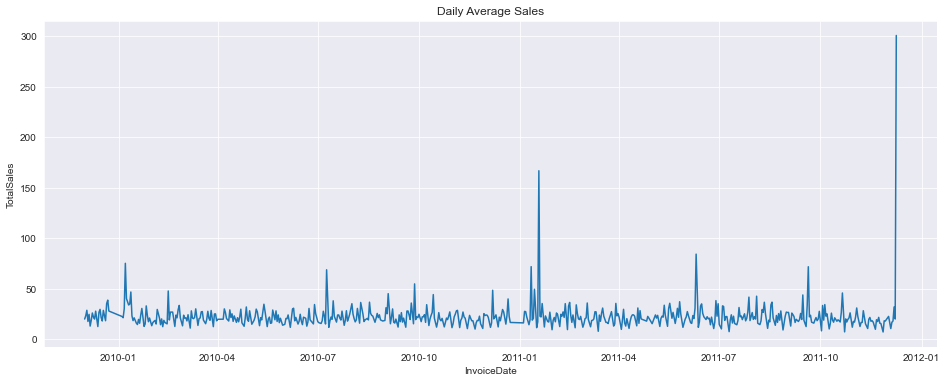

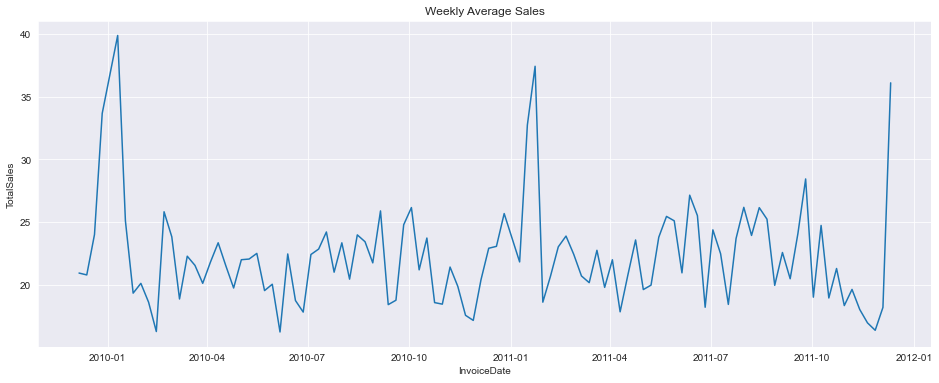

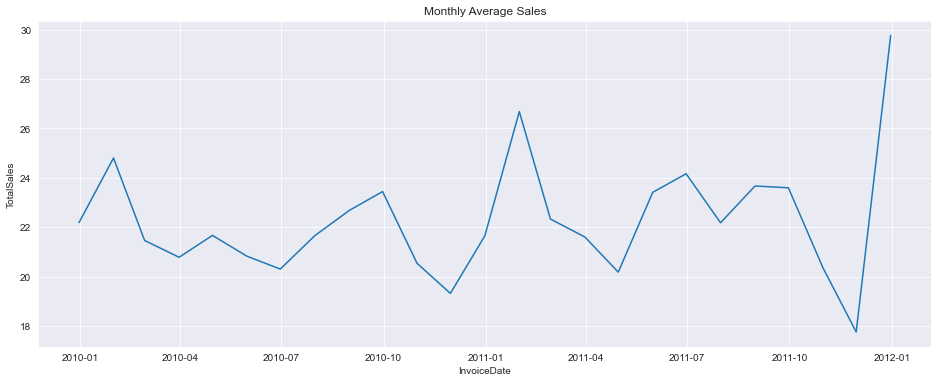

In [36]:
daily_avg_sales   = df[['InvoiceDate', 'TotalSales']].set_index('InvoiceDate').resample('D').mean()
weekly_avg_sales  = df[['InvoiceDate', 'TotalSales']].set_index('InvoiceDate').resample('W').mean()
monthly_avg_sales = df[['InvoiceDate', 'TotalSales']].set_index('InvoiceDate').resample('M').mean()


plt.figure(figsize=(16, 6))
sns.lineplot(data=daily_avg_sales, x=daily_avg_sales.index, y=daily_avg_sales.TotalSales, markers=True)
plt.title('Daily Average Sales');

plt.figure(figsize=(16, 6))
sns.lineplot(data=weekly_avg_sales, x=weekly_avg_sales.index, y=weekly_avg_sales.TotalSales, markers=True)
plt.title('Weekly Average Sales');

plt.figure(figsize=(16, 6))
sns.lineplot(data=monthly_avg_sales, x=monthly_avg_sales.index, y=monthly_avg_sales.TotalSales, markers=True)
plt.title('Monthly Average Sales');

<ipython-input-49-a764f6be39df>:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = xrot[i])
<ipython-input-49-a764f6be39df>:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = xrot[i])
<ipython-input-49-a764f6be39df>:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = xrot[i])


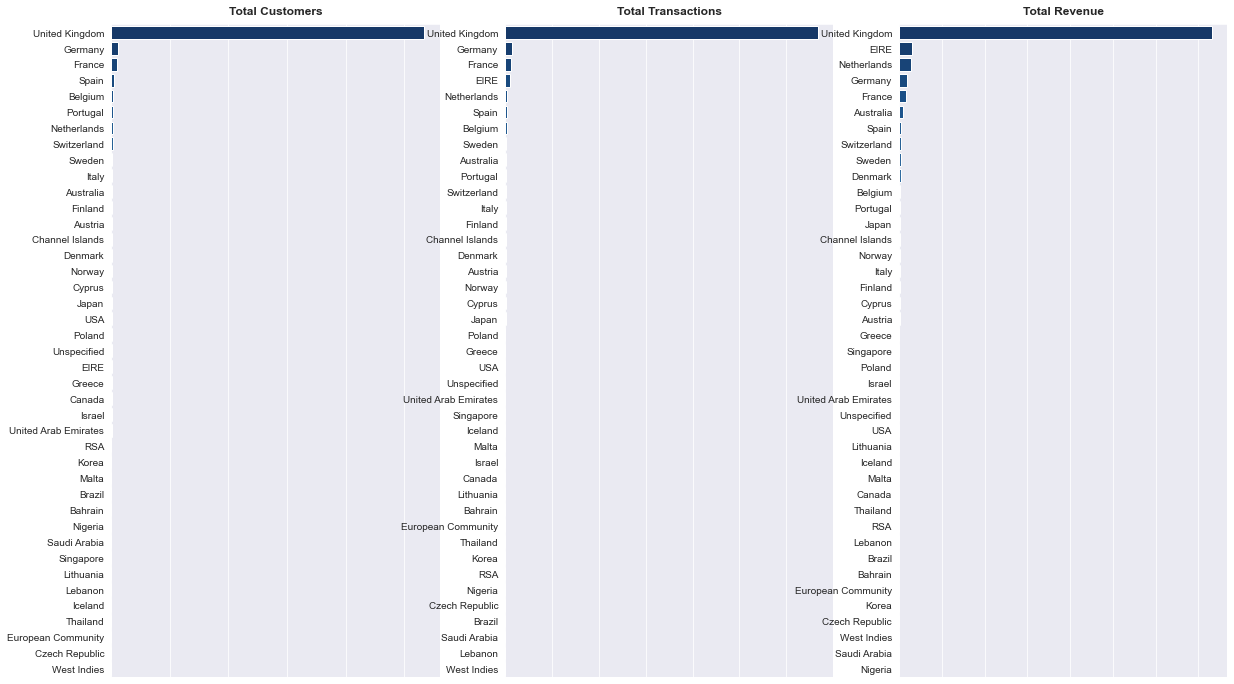

In [66]:
countries_custs = df.groupby('Country')['CustomerID'].nunique().reset_index().sort_values(by='CustomerID', ascending=False)
countries_trans = df.groupby('Country')['InvoiceNo'].nunique().reset_index().sort_values(by='InvoiceNo', ascending=False)
countries_pp = df.groupby('Country')['TotalSales'].sum().reset_index().sort_values(by='TotalSales', ascending=False)


func_barplot_autoplot( ncols       = 3,
                       plot_width  = 20,
                       plot_length = 12, 
                       x       = [countries_custs.CustomerID, countries_trans.InvoiceNo, countries_pp.TotalSales],
                       y       = [countries_custs.Country, countries_trans.Country, countries_pp.Country],
                       hue     = [None, None, None],
                       order   = [None, None, None],
                       height  = [0,0,0], 
                       total   = [None, None, None],
                       rot     = [None, None, None], 
                       title   = ['Total Customers', 'Total Transactions', 'Total Revenue'], 
                       xlabel  = [None, None, None],
                       ylabel  = [None, None, None],
                       xrot    = [None, None, None],
                       color   = [None, None, None],
                       palette = ['Blues_r', 'Blues_r', 'Blues_r'])

In [15]:
# Continent lists
eu_countries = ['United Kingdom', 'Germany', 'France', 'Spain', 'Belgium', 'Portugal', 'Netherlands', 
                'Switzerland', 'Malta', 'Czech Republic', 'Lithuania', 'Sweden', 'Italy', 'Finland', 
                'Austria', 'Channel Islands', 'Denmark', 'Norway', 'Cyprus', 'EIRE', 'Greece', 
                'European Community', 'Poland', 'Iceland' ]

me_countries = ['Saudi Arabia', 'Lebanon', 'Bahrain', 'United Arab Emirates', 'Israel']
as_countries = ['Japan', 'Australia', 'Korea', 'Singapore', 'Thailand']
af_countries = ['RSA', 'Nigeria']
am_countries = ['USA', 'Canada', 'Brazil', 'West Indies']

# Function to help extract continent based on customer's country
def extract_continent(country):
    if country in eu_countries: return 'Europe'
    elif country in me_countries: return 'Middle East'    
    elif country in as_countries: return 'Asia'
    elif country in af_countries: return 'Africa'
    elif country in am_countries: return 'America'
    else: return 'Unknown'
    
# Assign continent for each customer in the dataframe
df['continent'] = df.Country.apply(lambda x: extract_continent(x))

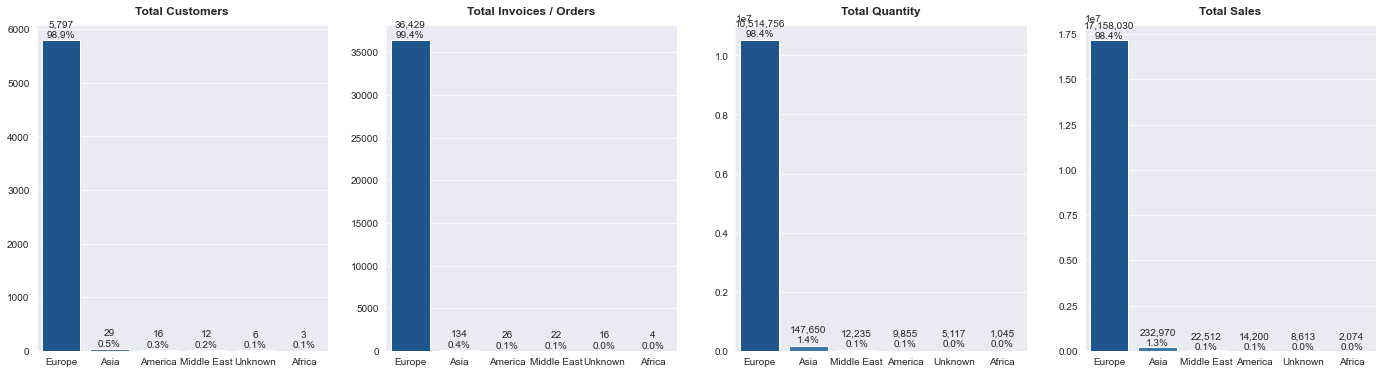

In [33]:
# Extract continent summary
continents_summary = df.groupby('continent').agg({'CustomerID': 'nunique', 'InvoiceNo': 'nunique', 'Quantity': 'sum', 'TotalSales': 'sum'}).reset_index()

# Prepare order lists for plotting
order_by_custs = continents_summary.sort_values(by='CustomerID', ascending=False)['continent'].tolist()
order_by_invid = continents_summary.sort_values(by='InvoiceNo', ascending=False)['continent'].tolist()
order_by_quant = continents_summary.sort_values(by='Quantity', ascending=False)['continent'].tolist()
order_by_sales = continents_summary.sort_values(by='TotalSales', ascending=False)['continent'].tolist()

# Plot 4 graphs
func_barplot_autoplot( ncols       = 4,
                       plot_width  = 24,
                       plot_length = 6, 
                       x       = [continents_summary.continent, continents_summary.continent, continents_summary.continent, continents_summary.continent],
                       y       = [continents_summary.CustomerID, continents_summary.InvoiceNo, continents_summary.Quantity, continents_summary.TotalSales],
                       hue     = [None, None, None, None],
                       order   = [order_by_custs, order_by_invid, order_by_quant, order_by_sales],
                       height  = [200, 1200, 400000, 500000], 
                       total   = [continents_summary.CustomerID.sum(), continents_summary.InvoiceNo.sum(), continents_summary.Quantity.sum(), continents_summary.TotalSales.sum()], 
                       rot     = [None, None, None, None], 
                       title   = ['Total Customers', 'Total Invoices / Orders', 'Total Quantity', 'Total Sales'], 
                       xlabel  = [None, None, None, None], 
                       ylabel  = [None, None, None, None],
                       xrot    = [None, None, None, None],
                       color   = [None, None, None, None],
                       palette = ['Blues_r', 'Blues_r', 'Blues_r', 'Blues_r'])

In [65]:
# To furthure investigate the data, and to avoid any bias in CLV model, I will split data by continent.
# I will start with EU countries

eu_df = df.loc[df.continent == 'Europe'].reset_index(drop=True).copy()
eu_df = eu_df.groupby(["InvoiceNo", "CustomerID", "InvoiceDate"])[["Quantity", "TotalSales"]].agg("sum").reset_index()

In [68]:
print(f'Minimum date: {eu_df.InvoiceDate.min()}')
print(f'Maximum date: {eu_df.InvoiceDate.max()}')

Minimum date: 2009-12-01 07:45:00
Maximum date: 2011-12-09 12:50:00


### **Business context**

<br>

<table style="width: 844px; float: left;" border="1">
<tbody>
<tr style="height: 23px;">
<td style="width: 243px; height: 23px;"><strong>Context</strong></td>
<td style="width: 197px; height: 23px;"><strong>Contractual</strong></td>
<td style="width: 30px; height: 23px;">&nbsp;</td>
<td style="width: 373px; height: 23px;"><strong>Non Contractual</strong></td>
</tr>
<tr style="height: 23px;">
<td style="width: 243px; height: 23px;"><strong>End of customer's relationship</strong></td>
<td style="width: 197px; height: 23px;">Observed</td>
<td style="width: 30px; height: 23px;">&nbsp;</td>
<td style="width: 373px; height: 23px;">Not observed</td>
</tr>
<tr style="height: 23px;">
<td style="width: 243px; height: 23px;"><strong>Common model</strong></td>
<td style="width: 197px; height: 23px;">Survival-base approach</td>
<td style="width: 30px; height: 23px;">&nbsp;</td>
<td style="width: 373px; height: 23px;">Customer lifetime distribution (often, exponential model)</td>
</tr>
<tr style="height: 23px;">
<td style="width: 243px; height: 23px;"><strong>Type</strong></td>
<td style="width: 197px; height: 23px;">Discrete</td>
<td style="width: 30px; height: 23px;">&nbsp;</td>
<td style="width: 373px; height: 23px;">Continious</td>
</tr>
<tr style="height: 23px;">
<td style="width: 243px; height: 23px;"><strong>Examples</strong></td>
<td style="width: 197px; height: 23px;">Costco</td>
<td style="width: 30px; height: 23px;">&nbsp;</td>
<td style="width: 373px; height: 23px;">Amazon.com</td>
</tr>
</tbody>
</table>

### **Probabilistic Model**

- In this exercise I will be using the BG/NBD predictive model which is the most commnly used one along with Pareto/NBD. The only difference between both model is that Pareto/NBD assumes dropout (customer become inactive) can happen at any point of time. 

- Asside form BG/NBD for transaction variables, I will be using Gamma-Gamma model for monetary variables.

In [136]:
from lifetimes import BetaGeoFitter, ParetoNBDFitter, ModifiedBetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_period_transactions 
from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data

In [137]:
# Split data

rfm_train_test = calibration_and_holdout_data(
                        eu_df, 
                        'CustomerID', 
                        'InvoiceDate', 
                        calibration_period_end='2011-10-01', 
                        observation_period_end='2011-12-09', 
                        monetary_value_col='TotalSales'
                    )

rfm_train_test = rfm_train_test.loc[rfm_train_test.frequency_cal > 0]
rfm_train_test.head(5)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346.00,2.00,322.00,578.00,38662.96,0.00,0.00,69.00
12347.00,5.00,275.00,335.00,700.53,2.00,759.57,69.00
12348.00,4.00,363.00,369.00,359.31,0.00,0.00,69.00
12349.00,1.00,182.00,520.00,1152.62,1.00,1457.55,69.00
12352.00,7.00,320.00,323.00,193.44,1.00,231.73,69.00


In [165]:
# Train the BG/NBD mode
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(rfm_train_test['frequency_cal'], rfm_train_test['recency_cal'], rfm_train_test['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 3680 subjects, a: 0.05, alpha: 63.83, b: 0.33, r: 0.94>

In [166]:
# Predict

num_days = (pd.to_datetime('2011-12-09') - pd.to_datetime('2011-10-01')).days

rfm_train_test['predicted'] = bgf.predict(
                                    num_days, 
                                    rfm_train_test['frequency_cal'], 
                                    rfm_train_test['recency_cal'], 
                                    rfm_train_test['T_cal']
                                )

In [167]:
def evaluave_clv(actual, predict, n_bins):
    
    from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score
    from sklearn.preprocessing import KBinsDiscretizer 

    bins_est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='kmeans')
    
    actual_bins    = bins_est.fit_transform(actual.values.reshape(-1,1))
    predicted_bins = bins_est.transform(predict.values.reshape(-1,1))

    df_cm = pd.DataFrame(confusion_matrix(actual_bins, predicted_bins), index = range(1, 11), columns = range(1, 11))

    fig, ax = plt.subplots(ncols = 2, figsize= (18, 6))
    hplot = sns.histplot(x=actual , bins=40, label='Actual', ax = ax[0])
    hplot = sns.histplot(x=predict, bins=40, label='Predicted', color='orange', ax = ax[0])
    hmap = sns.heatmap(df_cm, annot=True, ax = ax[1])
    hplot.set_title(f'Actual Vs.Predicted Distribution | MSE Score: {round(mean_squared_error(actual, predict), 4)}', pad = 10, weight= 'bold')
    hmap.set_title(f'Confusion Matrix | F1 Score: {round(f1_score(actual_bins, predicted_bins, average="macro"), 4)}', pad = 10, weight= 'bold')
    hplot.legend()
    plt.show()

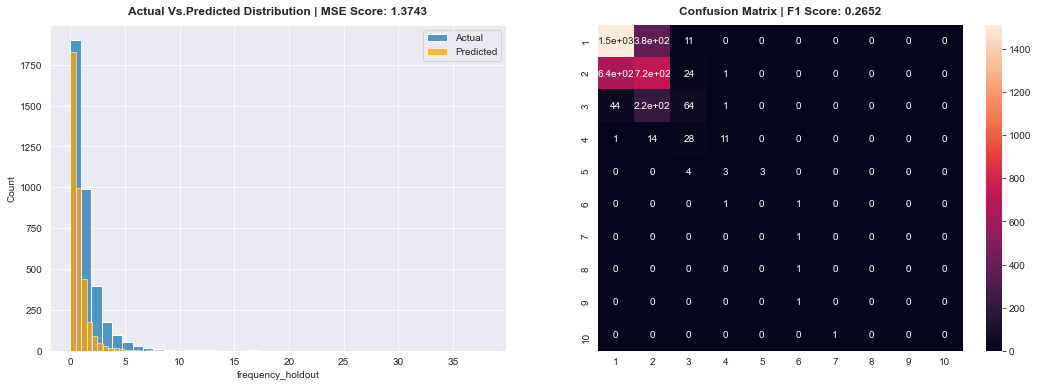

In [168]:
evaluave_clv(actual = rfm_train_test['frequency_holdout'], predict = rfm_train_test['predicted'], n_bins = 10)

In [169]:
rfm_train_test[['frequency_cal', 'monetary_value_cal']].corr()

,frequency_cal,monetary_value_cal
frequency_cal,1.00,0.09
monetary_value_cal,0.09,1.00


In [170]:
# GammaGammaFitter model fit
ggf = GammaGammaFitter(penalizer_coef = 0.01)
ggf.fit(rfm_train_test['frequency_cal'], rfm_train_test['monetary_value_cal'])

#Prediction
rfm_train_test['monetary_predicted'] = ggf.conditional_expected_average_profit(rfm_train_test['frequency_holdout'], rfm_train_test['monetary_value_holdout'])

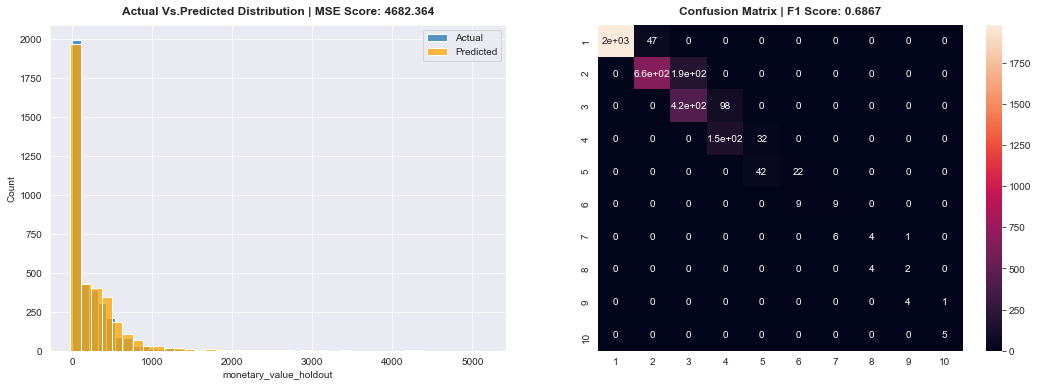

In [171]:
evaluave_clv(actual = rfm_train_test['monetary_value_holdout'], predict = rfm_train_test['monetary_predicted'], n_bins = 10)

In [172]:
rfm_train_test['clv'] = ggf.customer_lifetime_value(
                                        bgf, 
                                        rfm_train_test['frequency_cal'],
                                        rfm_train_test['recency_cal'],
                                        rfm_train_test['T_cal'],
                                        rfm_train_test['monetary_value_cal'],
                                        time=2, 
                                        discount_rate=0.01 
                                    )

rfm_train_test

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,predicted,monetary_predicted,clv
CustomerID,,,,,,,,,,
12346.00,2.00,322.00,578.00,38662.96,0.00,0.00,69.00,0.27,-21.05,9793.95
12347.00,5.00,275.00,335.00,700.53,2.00,759.57,69.00,0.99,834.45,618.27
12348.00,4.00,363.00,369.00,359.31,0.00,0.00,69.00,0.77,-21.05,249.11
12349.00,1.00,182.00,520.00,1152.62,1.00,1457.55,69.00,0.13,1771.31,151.20
12352.00,7.00,320.00,323.00,193.44,1.00,231.73,69.00,1.40,285.37,238.36
...,...,...,...,...,...,...,...,...,...,...
18280.00,1.00,117.00,325.00,180.60,0.00,0.00,69.00,0.20,-21.05,39.18
18281.00,1.00,397.00,508.00,80.82,0.00,0.00,69.00,0.19,-21.05,16.62
18283.00,13.00,563.00,589.00,127.32,5.00,162.37,69.00,1.46,169.02,161.72


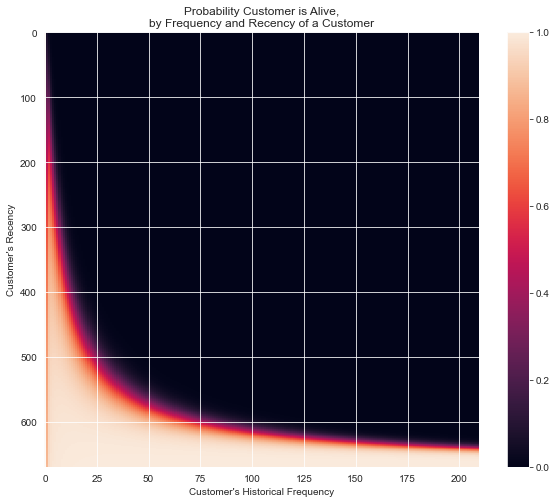

In [173]:
plt.figure(figsize=(10,8))
plot_probability_alive_matrix(model = bgf);

In [174]:
# Creating RFM object
# Train the entire EU dataset using the above models

summary = summary_data_from_transaction_data(
                transactions = eu_df, 
                customer_id_col = 'CustomerID', 
                datetime_col = 'InvoiceDate',
                monetary_value_col = 'TotalSales'
            )

summary.reset_index(inplace=True)
summary[:10]

,CustomerID,frequency,recency,T,monetary_value
0,12346.00,2.00,322.00,647.00,38662.96
1,12347.00,7.00,402.00,404.00,717.40
2,12348.00,4.00,363.00,438.00,359.31
3,12349.00,2.00,571.00,589.00,1305.08
4,12350.00,0.00,0.00,310.00,0.00
5,12352.00,8.00,356.00,392.00,198.22
6,12354.00,0.00,0.00,232.00,0.00
7,12356.00,5.00,402.00,424.00,963.05
8,12357.00,1.00,355.00,388.00,6207.67
9,12358.00,4.00,730.00,731.00,504.31


- **frequency** Number of repeat purchases (more than 1 purchases)
- **recency** Time between the first and the last transaction
- **T** Time between the first purchase and the end of the transaction period (last date of the time frame considered for the analysis)
- **monetary_value** — The mean of a given customers sales value<br>

**Note** some of the frequency and recency are 0 which means that these are one-time buyers

In [175]:
bg = BetaGeoFitter(penalizer_coef=0.1)    # Intantiate BG/NBD model
bg.fit(frequency = summary['frequency'], recency = summary['recency'], T = summary['T'])    # Fit model on Frequency, Recency and T

<lifetimes.BetaGeoFitter: fitted with 5797 subjects, a: 0.11, alpha: 63.70, b: 2.48, r: 0.67>

In [130]:
bg.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.67,0.02,0.64,0.70
alpha,63.70,1.96,59.86,67.53
a,0.11,0.02,0.08,0.14
b,2.48,0.55,1.41,3.56


The above table shows the estimated distribution parameter values from the historical data. The model now uses this to predict future transactions and the customer churn rate.

In [131]:
# To compute the probability if a customer is currently alive with history (frequency, recency, T).
summary['still_alive_proba'] = bg.conditional_probability_alive(
                                                frequency = summary['frequency'], 
                                                recency = summary['recency'], 
                                                T = summary['T']
                                             )

In [132]:
summary[:10]

,CustomerID,frequency,recency,T,monetary_value,still_alive_proba
0,12346.00,2.00,322.00,647.00,38662.96,0.86
1,12347.00,7.00,402.00,404.00,717.40,0.99
2,12348.00,4.00,363.00,438.00,359.31,0.96
3,12349.00,2.00,571.00,589.00,1305.08,0.97
4,12350.00,0.00,0.00,310.00,0.00,1.00
5,12352.00,8.00,356.00,392.00,198.22,0.98
6,12354.00,0.00,0.00,232.00,0.00,1.00
7,12356.00,5.00,402.00,424.00,963.05,0.98
8,12357.00,1.00,355.00,388.00,6207.67,0.95
9,12358.00,4.00,730.00,731.00,504.31,0.98


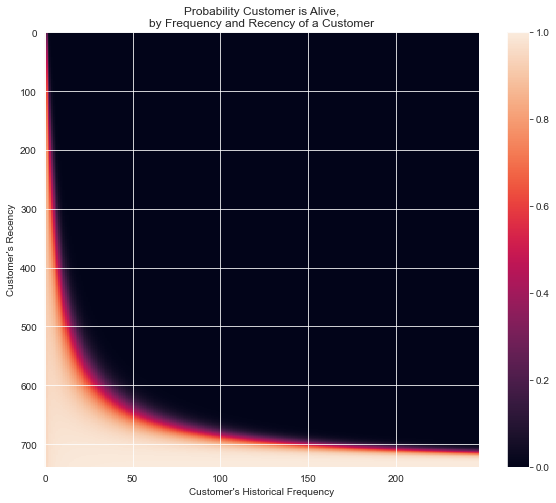

In [133]:
plt.figure(figsize = (10,8))
plot_probability_alive_matrix(model = bg);

Above graph shows that customers bought items multiple time with high recency (last transaction - fist transaction) is most likely to be alive. <br>
Similarly, customers bought few items (less frequence) with low recency, they are most likely also to be alive.

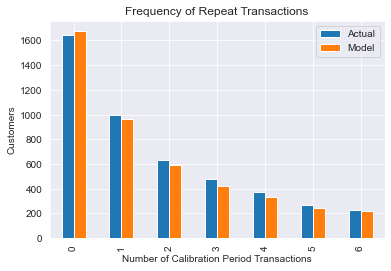

In [196]:
plot_period_transactions(bg);

In [179]:
# Predict future transactions for each customers

t = 30
summary['Predict_Num_Future_Trans'] = bg.conditional_expected_number_of_purchases_up_to_time(
                                                                        t = t,
                                                                        frequency = summary['frequency'], 
                                                                        recency = summary['recency'], 
                                                                        T = summary['T']
                                                                    )

summary.sort_values(by='Predict_Num_Future_Trans', ascending = False)[:10]

,CustomerID,frequency,recency,T,monetary_value,Predict_Num_Future_Trans
2473,14911.00,247.00,737.00,738.00,1119.31,9.24
361,12748.00,196.00,735.00,735.00,267.15,7.37
2869,15311.00,195.00,738.00,738.00,593.09,7.30
5355,17841.00,192.00,736.00,737.00,366.29,7.20
2175,14606.00,176.00,735.00,736.00,172.41,6.61
683,13089.00,131.00,735.00,737.00,888.32,4.92
2096,14527.00,120.00,735.00,737.00,223.56,4.51
1731,14156.00,117.00,729.00,738.00,2590.18,4.38
567,12971.00,98.00,721.00,724.00,162.36,3.74
1376,13798.00,98.00,730.00,731.00,768.91,3.71


CustomerID 14911 purchased 247 time in 737 days which means, 0.33 times a day. 0.33 * 30 days gives us 9.9 which is pretty close to 9.24. The reason for the difference is caused by the various assumptions about the customers, such as the dropout rate, customer lifetime being modeled as exponential distribution etc. <br>

We have used BG/NBD to predict future transactions, now we will use Gamma-Gamma to predict the monetary value.

**key assumptions of the Gamma-Gamma model are**:
1. The monetary value of a customer’s given transaction varies randomly around their average transaction value.
2. Average transaction value varies across customers but do not vary over time for any given customer.
3. The distribution of average transaction values across customers is independent of the transaction process.

Out of the above three assumptions, the final one can be validated. There should not be any relationship between the frequency and monetary value of transactions, which can be easily validated using the Pearson correlation.

**Note** *I will consider only customers who made repeat purchases with the business i.e., frequency > 0. If the frequency is 0, it means that they are a one-time customer and are considered already dead.*

In [180]:
returned_customers_summary_df = summary[summary.frequency > 0]
returned_customers_summary_df[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.00,0.02
monetary_value,0.02,1.00


Correlation coefficients whose magnitude are between 0.5 and 0.7 indicate variables which can be considered moderately correlated. Correlation coefficients whose magnitude are between 0.3 and 0.5 indicate variables which have a low correlation. Therefore, 0.19 considered as weak correlation which this satisfy the model's assumption and we can move to the next step to fit Gamma-Gamma model

In [181]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(returned_customers_summary_df['frequency'], returned_customers_summary_df['monetary_value'])
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.78,0.08,3.63,3.94
q,0.34,0.01,0.33,0.35
v,3.69,0.08,3.53,3.85


Now, I can predict the expected average profit for each transaction and Customer Lifetime Value using the model.

**model.conditional_expected_average_profit()**: This method computes the conditional expectation of the average profit per transaction for a group of one or more customers.<br>
**model.customer_lifetime_value()**: This method computes the average lifetime value of a group of one or more customers. This method takes in the BG/NBD model and the prediction horizon as a parameter to calculate the CLV.

In [182]:
summary = summary[summary.monetary_value > 0]

In [184]:
# Calculate the expected average profit for each customer per transaction

summary['Expected_avg_sales'] = ggf.conditional_expected_average_profit(summary['frequency'], summary['monetary_value'])
summary[:10]

,CustomerID,frequency,recency,T,monetary_value,Predict_Num_Future_Trans,Expected_avg_sales
0,12346.00,2.00,322.00,647.00,38662.96,0.10,42371.74
1,12347.00,7.00,402.00,404.00,717.40,0.48,736.33
2,12348.00,4.00,363.00,438.00,359.31,0.27,376.71
3,12349.00,2.00,571.00,589.00,1305.08,0.12,1432.23
5,12352.00,8.00,356.00,392.00,198.22,0.56,203.13
7,12356.00,5.00,402.00,424.00,963.05,0.34,998.74
8,12357.00,1.00,355.00,388.00,6207.67,0.11,7528.66
9,12358.00,4.00,730.00,731.00,504.31,0.17,528.34
10,12359.00,9.00,677.00,734.00,908.36,0.36,926.79
11,12360.00,5.00,603.00,655.00,698.98,0.23,725.09


In [185]:
# Check actual and expected mean

print(f'Actual average sales  : {summary.monetary_value.mean()}')
print(f'Expected average sales: {summary.Expected_avg_sales.mean()}')

Actual average sales  : 445.9924017706787
Expected average sales: 487.87668425810136


In [186]:
summary['Predicted_CLV'] = ggf.customer_lifetime_value(
                                        transaction_prediction_model = bg, 
                                        frequency = summary['frequency'], 
                                        recency = summary['recency'], 
                                        T = summary['T'], 
                                        monetary_value = summary['monetary_value'],
                                        time = 1,  # Time in months --> 30 days
                                        freq = 'D', 
                                        discount_rate = 0.01 # Default
                                    )

In [188]:
# We do not have profit margin to calculate the CLV profit, so, I will assume it's 25%

profit_margin = 0.25

summary['Predicted_Net_CLV'] = summary.Predicted_CLV * profit_margin
summary[:10]

,CustomerID,frequency,recency,T,monetary_value,Predict_Num_Future_Trans,Expected_avg_sales,Predicted_CLV,Predicted_Net_CLV
0,12346.00,2.00,322.00,647.00,38662.96,0.10,42371.74,4062.09,1015.52
1,12347.00,7.00,402.00,404.00,717.40,0.48,736.33,352.82,88.21
2,12348.00,4.00,363.00,438.00,359.31,0.27,376.71,99.60,24.90
3,12349.00,2.00,571.00,589.00,1305.08,0.12,1432.23,167.96,41.99
5,12352.00,8.00,356.00,392.00,198.22,0.56,203.13,111.77,27.94
7,12356.00,5.00,402.00,424.00,963.05,0.34,998.74,336.46,84.11
8,12357.00,1.00,355.00,388.00,6207.67,0.11,7528.66,785.09,196.27
9,12358.00,4.00,730.00,731.00,504.31,0.17,528.34,90.24,22.56
10,12359.00,9.00,677.00,734.00,908.36,0.36,926.79,326.06,81.51
11,12360.00,5.00,603.00,655.00,698.98,0.23,725.09,165.28,41.32


In [189]:
summary.Predicted_CLV.describe()

count    4150.00
mean      180.23
std       863.82
min         0.00
25%        29.77
50%        70.72
75%       159.67
max     35939.01
Name: Predicted_CLV, dtype: float64

In [190]:
summary.Predicted_Net_CLV.describe()

count   4150.00
mean      45.06
std      215.96
min        0.00
25%        7.44
50%       17.68
75%       39.92
max     8984.75
Name: Predicted_Net_CLV, dtype: float64

In [197]:
# Reusable Function for production

### **Cohorts Analysis**

In [198]:
eu_df['begining_month'] = pd.to_datetime(eu_df.InvoiceDate.dt.strftime('%Y-%m-1'))
eu_df['cohort_month']   = eu_df.groupby('CustomerID')['begining_month'].transform('min')

In [199]:
# Creating the CohortIndex 

def get_year_month(df, col):
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    return year, month, day

invoice_year, invoice_month, invoice_day = get_year_month(eu_df, 'begining_month')
cohort_year, cohort_month, cohort_day = get_year_month(eu_df, 'cohort_month')

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

eu_df['CohortIndex'] = year_diff * 12 + month_diff + 1

In [200]:
def generate_pivot(operation, cohort_month, cohort_index, value, title):
    
    if operation == 'count':
        data = eu_df.groupby([cohort_month, cohort_index])[value].nunique().reset_index()
    else:
        data = eu_df.groupby([cohort_month, cohort_index])[value].mean().reset_index()
    
    data = data.pivot(index = cohort_month, columns = cohort_index, values = value)
    first_cohort_size = data.iloc[:,0]
    data = data.divide(first_cohort_size, axis= 0).round(3) * 100
  
    plt.figure(figsize= (16,8))
    sns.heatmap(data, yticklabels = data.index.astype('str'), fmt ='g', annot = True,  cmap = 'BuGn', vmax = 100)
    plt.title(title, pad = 10, weight= 'bold')
    plt.show()

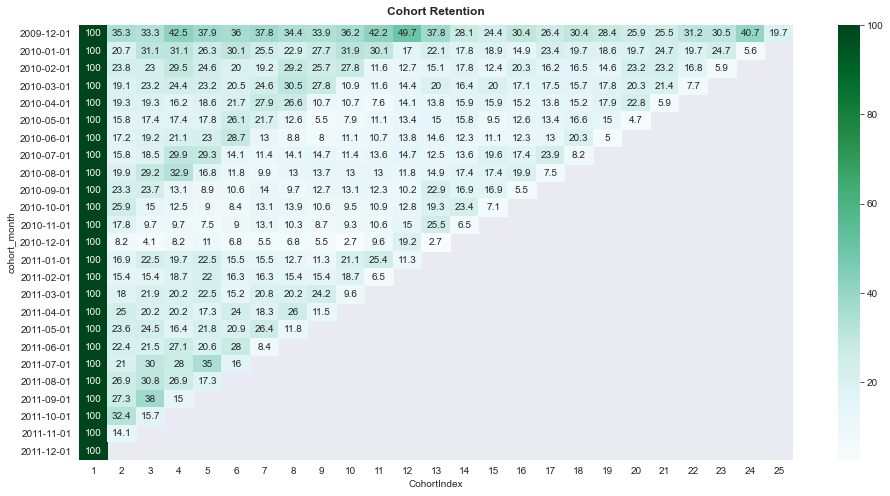

In [201]:
generate_pivot(operation = 'count', cohort_month = 'cohort_month', cohort_index = 'CohortIndex', value = 'CustomerID', title = 'Cohort Retention')

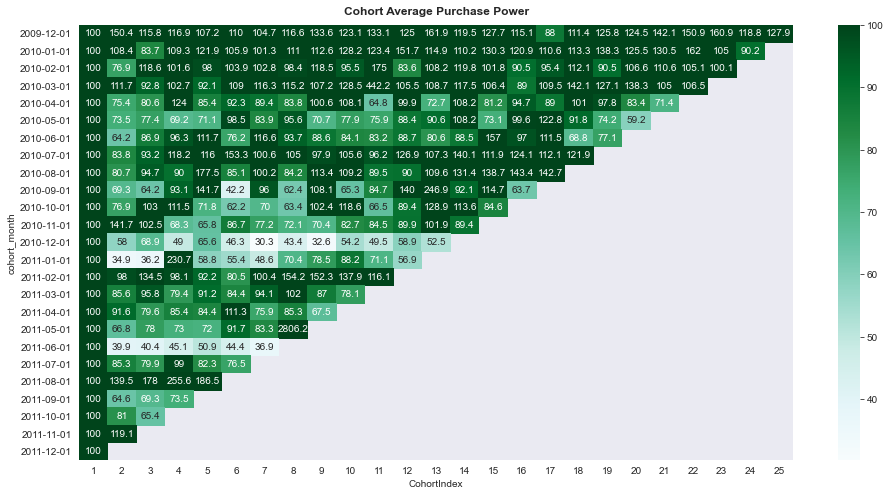

In [202]:
generate_pivot(operation = 'mean', cohort_month = 'cohort_month', cohort_index = 'CohortIndex', value = 'TotalSales', title = 'Cohort Average Purchase Power')

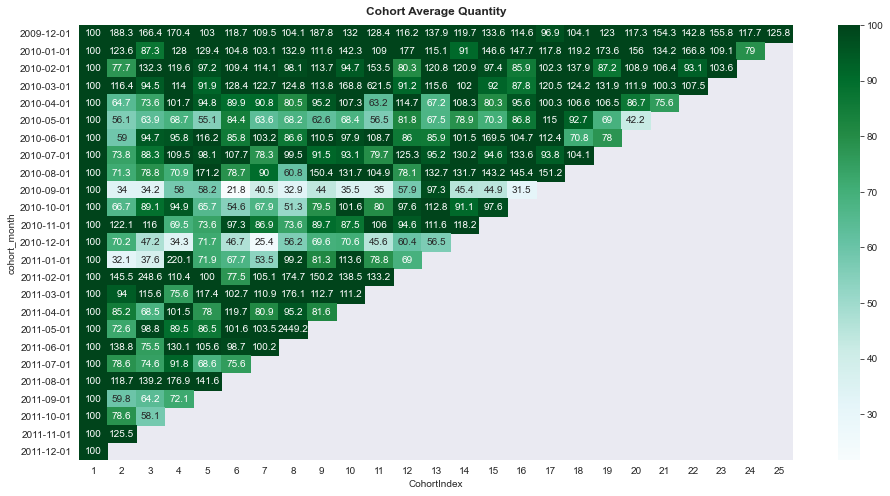

In [203]:
generate_pivot(operation = 'mean', cohort_month = 'cohort_month', cohort_index = 'CohortIndex', value = 'Quantity', title = 'Cohort Average Quantity')

In [204]:
import datetime as td 

snap_date = eu_df.InvoiceDate.dt.date.max() + td.timedelta(days = 1)
RFM_Segmentation = eu_df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (snap_date - x.dt.date.max()).days, 'InvoiceNo': 'nunique', 'TotalSales': 'sum'})
RFM_Segmentation.rename(columns = {'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalSales': 'MonetaryValue'}, inplace = True)

RFM_Segmentation['R'] = pd.qcut(x = RFM_Segmentation.Recency, q = 5, labels = range(5, 0, -1)).values
RFM_Segmentation['F'] = pd.qcut(x = RFM_Segmentation.Frequency.rank(method='first'),  q = 5, labels = range(1,6)).values # I had to add .rank() method to avoid the error
RFM_Segmentation['M'] = pd.qcut(x = RFM_Segmentation.MonetaryValue, q = 5, labels = range(1,6)).values

RFM_Segmentation['segment'] = RFM_Segmentation.R.astype(str) + RFM_Segmentation.F.astype(str) + RFM_Segmentation.M.astype(str)
RFM_Segmentation['segment_score'] = RFM_Segmentation.R.astype(int) + RFM_Segmentation.F.astype(int) + RFM_Segmentation.M.astype(int)

In [205]:
def func_customized_group(x):    
    if x > 13: return 'Elite'
    elif x > 10: return 'Gold'
    elif x > 5: return 'Silver'
    else: return 'Bronze'
    
RFM_Segmentation['group'] = RFM_Segmentation.segment_score.apply(lambda x: func_customized_group(x))

In [206]:
group_order = ['Elite', 'Gold', 'Silver', 'Bronze']

groups_members = RFM_Segmentation.groupby('group').size().reset_index().rename(columns={0: 'counts'})
groups_purchase_power =RFM_Segmentation.groupby('group').agg({'MonetaryValue': 'sum'}).reset_index()

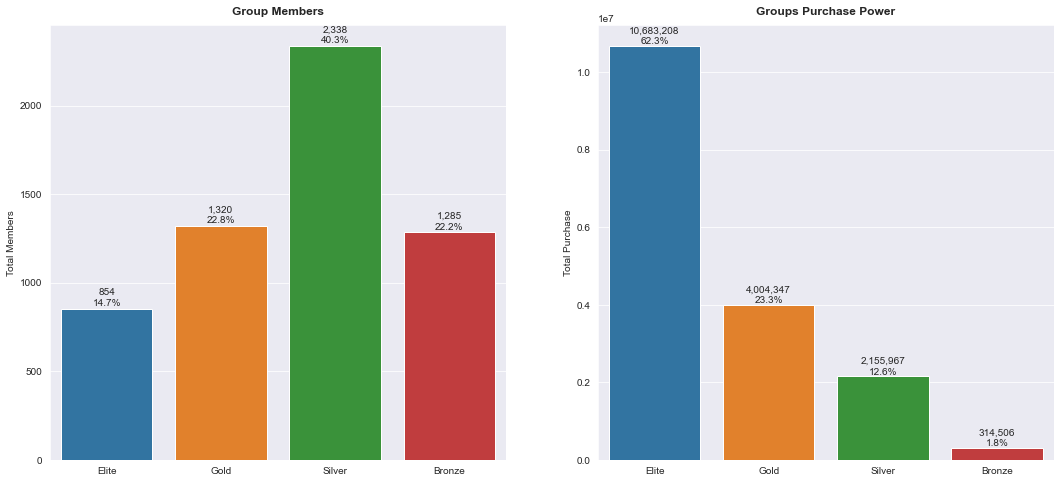

In [211]:
func_barplot_autoplot( ncols       = 2,
                       plot_width  = 18,
                       plot_length = 8, 
                       x       = [groups_members.group, groups_purchase_power.group],
                       y       = [groups_members.counts, groups_purchase_power.MonetaryValue],
                       hue     = [None, None],
                       order   = [group_order, group_order],
                       height  = [60, 250000], 
                       total   = [groups_members.counts.sum(), groups_purchase_power.MonetaryValue.sum()], 
                       rot     = [None, None], 
                       title   = ['Group Members', 'Groups Purchase Power'], 
                       xlabel  = ['', ''], 
                       ylabel  = ['Total Members', 'Total Purchase'],
                       xrot    = [None, None],
                       color   = [None, None], # 'skyblue'
                       palette = [None, None])